In [1]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

set_gpu()

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
path = 'C:/Users/yteh/Documents/work/necal/home data/TR58/DATA/MAT/'
all_files = os.listdir(path)
train_file = all_files[0]
train_file2 = all_files[1]

In [3]:
all_files = np.delete(all_files,0)

In [4]:
train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [5]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [6]:
# Initial training
ep = 30
n_dof = len(train_dof)

trainmlp, traincnn, y_train, x_train_mlp, x_train_cnn, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=64)
mlp, cnn, w, c = lp.train_models(traincnn, trainmlp, x_train_lda, y_train_lda, n_dof, ep)

In [7]:
# Test all controllers without recalibration or adaptation
acc = np.empty((len(all_files),3))

for i in range(1,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof))
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

Set: 20170730_055812 CNN Accuracy: 74.46, MLP Accuracy: 76.19, LDA Accuracy: 72.57
Set: 20170730_060537 CNN Accuracy: 70.54, MLP Accuracy: 74.76, LDA Accuracy: 71.64
Set: 20170730_123937 CNN Accuracy: 72.69, MLP Accuracy: 77.67, LDA Accuracy: 66.67
Set: 20170731_123147 CNN Accuracy: 70.67, MLP Accuracy: 70.88, LDA Accuracy: 56.09
Set: 20170801_053500 CNN Accuracy: 68.90, MLP Accuracy: 71.26, LDA Accuracy: 59.38
Set: 20170801_054938 CNN Accuracy: 64.94, MLP Accuracy: 66.16, LDA Accuracy: 58.49
Set: 20170801_065547 CNN Accuracy: 71.18, MLP Accuracy: 75.05, LDA Accuracy: 58.28
Set: 20170802_050945 CNN Accuracy: 72.31, MLP Accuracy: 70.92, LDA Accuracy: 61.44
Set: 20170802_051732 CNN Accuracy: 65.91, MLP Accuracy: 68.06, LDA Accuracy: 68.23
Set: 20170802_052140 CNN Accuracy: 70.88, MLP Accuracy: 72.14, LDA Accuracy: 60.05
Set: 20170807_153152 CNN Accuracy: 68.56, MLP Accuracy: 68.39, LDA Accuracy: 64.14
Set: 20170807_153559 CNN Accuracy: 60.05, MLP Accuracy: 60.39, LDA Accuracy: 52.63
Set:

In [8]:
# Test all controllers with adaptation
ep = 3
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
adapt_acc = np.empty((len(all_files),3))
adapt_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    adapt_file = all_files[i]
    adapt_data, adapt_params = prd.load_caps_train(path + adapt_file + '/traindata.mat')
    adapt_data = adapt_data[:,:8,:]

    # check class labels
    adapt_data, adapt_params = lp.check_labels(adapt_data, adapt_params, train_dof, key)
    
    adaptmlp, adaptcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(adapt_data, adapt_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale)
    mlp, cnn, w, c = lp.train_models(adaptcnn, adaptmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof)
    adapt_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Adapt: ' + adapt_file + ', Test: ' + test_file, f', CNN Accuracy: {adapt_acc[i+1,2]:.2f},', f'MLP Accuracy: {adapt_acc[i+1,1]:.2f},', f'LDA Accuracy: {adapt_acc[i+1,0]:.2f}')

Adapt: 20170730_055812, Test: 20170730_060537 , CNN Accuracy: 75.01, MLP Accuracy: 80.19, LDA Accuracy: 71.09
Adapt: 20170730_123937, Test: 20170731_123147 , CNN Accuracy: 67.47, MLP Accuracy: 67.17, LDA Accuracy: 50.74
Adapt: 20170801_053500, Test: 20170801_054938 , CNN Accuracy: 69.03, MLP Accuracy: 70.80, LDA Accuracy: 56.93
Adapt: 20170801_065547, Test: 20170802_050945 , CNN Accuracy: 72.57, MLP Accuracy: 72.14, LDA Accuracy: 68.27
Adapt: 20170802_051732, Test: 20170802_052140 , CNN Accuracy: 64.14, MLP Accuracy: 70.00, LDA Accuracy: 50.74
Adapt: 20170807_153152, Test: 20170807_153559 , CNN Accuracy: 64.31, MLP Accuracy: 70.42, LDA Accuracy: 58.74
Adapt: 20170808_054353, Test: 20170808_063929 , CNN Accuracy: 71.43, MLP Accuracy: 72.57, LDA Accuracy: 65.87
Missing classes
Adapt: 20170808_104400, Test: 20170913_053927 , CNN Accuracy: 48.98, MLP Accuracy: 61.11, LDA Accuracy: 10.72
Missing classes
Missing classes
Adapt: 20170913_061042, Test: 20170915_173323 , CNN Accuracy: 72.72, MLP

In [9]:
# Test all controllers with recalibration
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
recal_acc = np.empty((len(all_files),3))
recal_acc[:] = np.nan

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    recal_file = all_files[i]
    recal_data, recal_params = prd.load_caps_train(path + recal_file + '/traindata.mat')
    recal_data = recal_data[:,:8,:]

    recal_dof = np.unique(recal_params[:,2])
    recal_key = np.empty(recal_dof.shape)
    for dof_i in range(len(recal_dof)):
        recal_key[dof_i] = recal_params[np.argmax(recal_params[:,2] == recal_dof[dof_i]),0]
    n_recal_dof = len(recal_dof)
    
    recalmlp, recalcnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(recal_data, recal_params, prop_b = False)
    mlp, cnn, w, c = lp.train_models(recalcnn, recalmlp, x_train_lda, y_train_lda, n_recal_dof, ep)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,recal_dof,recal_key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_recal_dof)
    recal_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, w, c)

    print ('Recal: ' + recal_file + ', Test: ' + test_file, f', CNN Accuracy: {recal_acc[i+1,2]:.2f},', f'MLP Accuracy: {recal_acc[i+1,1]:.2f},', f'LDA Accuracy: {recal_acc[i+1,0]:.2f}')

Recal: 20170730_055812, Test: 20170730_060537 , CNN Accuracy: 75.77, MLP Accuracy: 74.59, LDA Accuracy: 71.09
Recal: 20170730_123937, Test: 20170731_123147 , CNN Accuracy: 67.34, MLP Accuracy: 68.48, LDA Accuracy: 50.74
Recal: 20170801_053500, Test: 20170801_054938 , CNN Accuracy: 63.34, MLP Accuracy: 68.31, LDA Accuracy: 56.93
Recal: 20170801_065547, Test: 20170802_050945 , CNN Accuracy: 67.80, MLP Accuracy: 69.74, LDA Accuracy: 68.27
Recal: 20170802_051732, Test: 20170802_052140 , CNN Accuracy: 63.46, MLP Accuracy: 66.92, LDA Accuracy: 50.74
Recal: 20170807_153152, Test: 20170807_153559 , CNN Accuracy: 73.62, MLP Accuracy: 66.20, LDA Accuracy: 58.74
Recal: 20170808_054353, Test: 20170808_063929 , CNN Accuracy: 70.12, MLP Accuracy: 66.25, LDA Accuracy: 65.87
Missing classes
Recal: 20170808_104400, Test: 20170913_053927 , CNN Accuracy: 49.87, MLP Accuracy: 42.63, LDA Accuracy: 10.72
Recal: 20170913_061042, Test: 20170915_173323 , CNN Accuracy: 69.44, MLP Accuracy: 66.01, LDA Accuracy: 

In [10]:
if acc.shape[0] > recal_acc.shape[0]:
    acc = np.delete(acc,-1,axis=0)

In [28]:
colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)
col = np.empty((7,4))
col[0,:] = np.array([0,0,0,1])
col[1,:] = c[8,:]
col[2,:] = c[0,:]
col[3,:] = c[9,:]
col[4,:] = c[1,:]
col[5,:] = c[10,:]
col[6,:] = c[2,:]

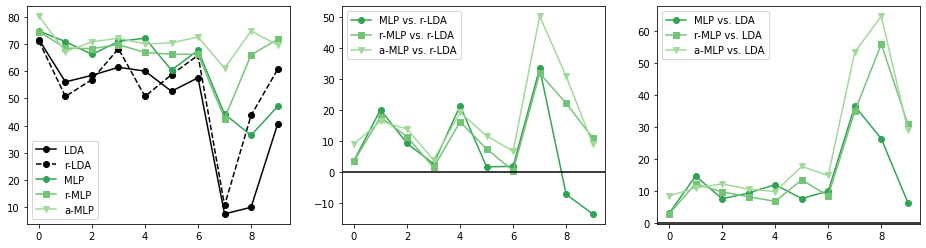

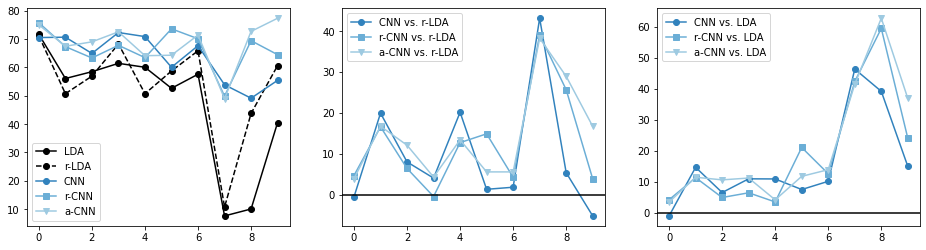

In [32]:
for mod in range(1,3):
    nnVlda = acc[:,mod] - acc[:,0]
    annVlda = adapt_acc[:,mod] - acc[:,0]
    rnnVlda = recal_acc[:,mod] - acc[:,0]
    nnVrlda = acc[:,mod] - recal_acc[:,0]
    annVrlda = adapt_acc[:,mod] - adapt_acc[:,0]
    rnnVrlda = recal_acc[:,mod] - recal_acc[:,0]
    mask = ~np.isnan(annVrlda)
    
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    ax[0].plot(acc[mask,0],'o-',color=col[0,:])
    ax[0].plot(recal_acc[mask,0], 'o--',color=col[0,:])
    ax[0].plot(acc[mask,mod],'o-',color=col[mod,:])
    ax[0].plot(recal_acc[mask,mod], 's-',color=col[mod+2,:])
    ax[0].plot(adapt_acc[mask,mod], 'v-',color=col[mod+4,:])
    if mod == 1:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', ])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN'])

    ax[1].plot(nnVrlda[mask],'o-',color=col[mod,:])
    ax[1].plot(rnnVrlda[mask],'s-',color=col[mod+2,:])
    ax[1].plot(annVrlda[mask],'v-',color=col[mod+4,:])
    if mod == 1:
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA'])
    else:
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA'])
    ax[1].axhline(0, color='black')

    ax[2].plot(nnVlda[mask],'o-',color=col[mod,:])
    ax[2].plot(rnnVlda[mask],'s-',color=col[mod+2,:])
    ax[2].plot(annVlda[mask],'v-',color=col[mod+4,:])
    if mod == 1:
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA'])
    else:
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA'])
    ax[2].axhline(0, color='black')

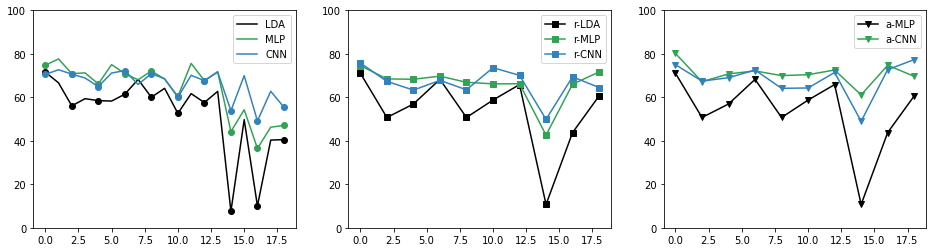

In [33]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    ax[1].plot(x_skip,recal_acc[mask,i], 's-',color=col[i,:])

    ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  